In [40]:
# %load ../titanic/mlpack.py
#Suppress Warninings
import warnings
import requests 
import json
from dask import delayed, compute
import dask

from matplotlib import pyplot as plt

from scipy.stats import zscore
import collections

from dask.diagnostics import ProgressBar
ProgressBar().register()

warnings.filterwarnings('ignore')

#Simpled desiged function to give a birds eye look into the dataset.

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import seaborn as sb
from sklearn.metrics import accuracy_score,r2_score,classification_report, roc_auc_score
from sklearn.preprocessing import LabelEncoder,OneHotEncoder, StandardScaler, Normalizer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold,StratifiedKFold, cross_val_score
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier,AdaBoostClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from imblearn.over_sampling import SMOTE

def read_basic(name=None):
    if(name==None):
        raise ValueError('No File Name provided')
        return 0
    print('-------------------{}----------------'.format(name))
    df = pd.read_csv(name)
    print('Datatypes: \n', df.dtypes)
    print('-----------------------------\n')
    print('Dimension: \n', df.shape)
    print('-----------------------------\n')
    print('Missing values per column: \n', df.isna().sum())
    print('-----------------------------\n')
    print('Dataframe Info: \n', df.info())
    print('-----------------------------\n')
    print('Descriptive Stats: \n', df.describe())

    return df# %load mlpack.py


# AS per the second dataset on Kaggle, the block code information can be obtained using the API:
# https://geo.fcc.gov/api/census/#!/block/get_block_find. We use this to find the appropraiate block code
# for all lat,long pairs in the NYC dataset.
# @delayed
# def fips_code(lat, long):
#     url = 'https://geo.fcc.gov/api/census/block/find?latitude={}&longitude={}&format=json'.format(lat,long)
#     r = str(requests.get(url = url).content)
# #     print(r)
# #     print(r.find('FIPS'))
#     return np.int(r[r.find('FIPS')+7:r.find("bbox")-3])
# #     msg = r.content.decode()
# #     return np.int(json.loads(msg)['Block']['FIPS'])


# delayed_results = [nyc_pred.fips_code(x) for x in range(nyc_pred.nyc_df.shape[0])]

# with ProgressBar():
# 	fips_codes = compute(*delayed_results)
# np.save('block_code_nyc.npy', fips_codes)

In [41]:
nyc_foursquare_df = read_basic('dataset_TSMC2014_NYC.csv')
nyc_foursquare_df['CensusTract'] = np.load('block_code_nyc.npy')
nyc_foursquare_df.CensusTract = nyc_foursquare_df.CensusTract.apply(lambda x: str(x)[:11])
nyc_foursquare_df.head()

-------------------dataset_TSMC2014_NYC.csv----------------
Datatypes: 
 userId               int64
venueId             object
venueCategoryId     object
venueCategory       object
latitude           float64
longitude          float64
timezoneOffset       int64
utcTimestamp        object
dtype: object
-----------------------------

Dimension: 
 (227428, 8)
-----------------------------

Missing values per column: 
 userId             0
venueId            0
venueCategoryId    0
venueCategory      0
latitude           0
longitude          0
timezoneOffset     0
utcTimestamp       0
dtype: int64
-----------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227428 entries, 0 to 227427
Data columns (total 8 columns):
userId             227428 non-null int64
venueId            227428 non-null object
venueCategoryId    227428 non-null object
venueCategory      227428 non-null object
latitude           227428 non-null float64
longitude          227428 non-null float64
timezo

,userId,venueId,venueCategoryId,venueCategory,latitude,longitude,timezoneOffset,utcTimestamp,CensusTract
0,470,49bbd6c0f964a520f4531fe3,4bf58dd8d48988d127951735,Arts & Crafts Store,40.719810,-74.002581,-240,Tue Apr 03 18:00:09 +0000 2012,36061003300
1,979,4a43c0aef964a520c6a61fe3,4bf58dd8d48988d1df941735,Bridge,40.606800,-74.044170,-240,Tue Apr 03 18:00:25 +0000 2012,36085001800
2,69,4c5cc7b485a1e21e00d35711,4bf58dd8d48988d103941735,Home (private),40.716162,-73.883070,-240,Tue Apr 03 18:02:24 +0000 2012,36081065900
3,395,4bc7086715a7ef3bef9878da,4bf58dd8d48988d104941735,Medical Center,40.745164,-73.982519,-240,Tue Apr 03 18:02:41 +0000 2012,36061007200
4,87,4cf2c5321d18a143951b5cec,4bf58dd8d48988d1cb941735,Food Truck,40.740104,-73.989658,-240,Tue Apr 03 18:03:00 +0000 2012,36061005600


## Read and process source data into pandas dataframe

In [42]:
#1.	Import NYC check-in dataset(dataset_TSMC2014_NYC.csv) into python
nyc_census_checkin_df = nyc_foursquare_df[['latitude', 'longitude', 'CensusTract']]

# 2.	Convert Coordinates in the dataset to census tracts and output the file to census_tracts_per_checkin.csv
# 3.	Add a census tract column to the census_tracts_per_checkin.csv file. Make sure this column is the same as the dataset_TSMC2014_NYC.csv file
nyc_census_checkin_df.to_csv('census_tracts_per_checkin.csv')

In [43]:
# 4.	Import NYC census dataset into python(nyc_census_tracts.csv)
nyc_census_tracts_df = read_basic('nyc_census_tracts.csv')

-------------------nyc_census_tracts.csv----------------
Datatypes: 
 CensusTract          int64
County              object
Borough             object
TotalPop             int64
Men                  int64
Women                int64
Hispanic           float64
White              float64
Black              float64
Native             float64
Asian              float64
Citizen              int64
Income             float64
IncomeErr          float64
IncomePerCap       float64
IncomePerCapErr    float64
Poverty            float64
ChildPoverty       float64
Professional       float64
Service            float64
Office             float64
Construction       float64
Production         float64
Drive              float64
Carpool            float64
Transit            float64
Walk               float64
OtherTransp        float64
WorkAtHome         float64
MeanCommute        float64
Employed             int64
PrivateWork        float64
PublicWork         float64
SelfEmployed       float64
FamilyWork  

In [44]:
# 5.	Create a dataset from 4 that excludes all null values of the income variable from nyc_census_tracts.csv and 
nyc_census_tracts_df = nyc_census_tracts_df[~nyc_census_tracts_df.Income.isna()]
print('Shape of Census Tract dataset: ',  nyc_census_tracts_df.shape)
nyc_census_tracts_df.isna().sum()

Shape of Census Tract dataset:  (2101, 36)


CensusTract        0
County             0
Borough            0
TotalPop           0
Men                0
Women              0
Hispanic           0
White              0
Black              0
Native             0
Asian              0
Citizen            0
Income             0
IncomeErr          0
IncomePerCap       0
IncomePerCapErr    0
Poverty            0
ChildPoverty       4
Professional       0
Service            0
Office             0
Construction       0
Production         0
Drive              0
Carpool            0
Transit            0
Walk               0
OtherTransp        0
WorkAtHome         0
MeanCommute        3
Employed           0
PrivateWork        0
PublicWork         0
SelfEmployed       0
FamilyWork         0
Unemployment       0
dtype: int64

In [45]:
# 6.	Create a separate dataset consisting of the census_tract column alone
census_tract_only_df = nyc_census_checkin_df[['CensusTract']]
census_tract_only_df.info()

# 7.	Calculate the total number of checkins per census tract and include it as a separate column in 6
check_in_counts = collections.Counter(census_tract_only_df.CensusTract.values)
census_tract_only_df['num_checkins'] = census_tract_only_df.CensusTract.apply(lambda x: check_in_counts[x])
census_tract_only_df.CensusTract = census_tract_only_df.CensusTract.apply(np.int)
census_tract_only_df.info()
census_tract_only_df.head()

#It is a good idea to drop duplicates
# print()
census_tract_only_df = census_tract_only_df[~census_tract_only_df.CensusTract.duplicated()]
census_tract_only_df.info()
census_tract_only_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227428 entries, 0 to 227427
Data columns (total 1 columns):
CensusTract    227428 non-null object
dtypes: object(1)
memory usage: 1.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227428 entries, 0 to 227427
Data columns (total 2 columns):
CensusTract     227428 non-null int64
num_checkins    227428 non-null int64
dtypes: int64(2)
memory usage: 3.5 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2612 entries, 0 to 226898
Data columns (total 2 columns):
CensusTract     2612 non-null int64
num_checkins    2612 non-null int64
dtypes: int64(2)
memory usage: 61.2 KB


,CensusTract,num_checkins
0,36061003300,745
1,36085001800,175
2,36081065900,112
3,36061007200,1747
4,36061005600,2345


In [46]:
# 8.	Merge datasets created in 5 and 7
print('SHapes before merge: ', nyc_census_tracts_df.shape, census_tract_only_df.shape )
nyc_merge_census_tract_df = nyc_census_tracts_df.merge(census_tract_only_df, on='CensusTract', how='inner')
print('Shape of merge dataset: ',nyc_merge_census_tract_df.shape)
nyc_merge_census_tract_df.head()

SHapes before merge:  (2101, 36) (2612, 2)
Shape of merge dataset:  (1881, 37)


,CensusTract,County,Borough,TotalPop,Men,Women,Hispanic,White,Black,Native,...,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment,num_checkins
0,36005000200,Bronx,Bronx,5403,2659,2744,75.8,2.3,16.0,0.0,...,0.0,0.0,43.0,2308,80.8,16.2,2.9,0.0,7.7,1
1,36005000400,Bronx,Bronx,5915,2896,3019,62.7,3.6,30.7,0.0,...,0.5,2.1,45.0,2675,71.7,25.3,2.5,0.6,9.5,1
2,36005001600,Bronx,Bronx,5879,2558,3321,65.1,1.6,32.4,0.0,...,1.6,1.7,38.8,2120,75.0,21.3,3.8,0.0,8.7,76
3,36005001900,Bronx,Bronx,2591,1206,1385,55.4,9.0,29.0,0.0,...,2.4,6.2,45.4,1083,76.8,15.5,7.7,0.0,19.2,77
4,36005002000,Bronx,Bronx,8516,3301,5215,61.1,1.6,31.1,0.3,...,1.0,0.0,46.0,2508,71.0,21.3,7.7,0.0,17.2,4


In [47]:
nyc_merge_census_tract_df.isna().sum()

CensusTract        0
County             0
Borough            0
TotalPop           0
Men                0
Women              0
Hispanic           0
White              0
Black              0
Native             0
Asian              0
Citizen            0
Income             0
IncomeErr          0
IncomePerCap       0
IncomePerCapErr    0
Poverty            0
ChildPoverty       3
Professional       0
Service            0
Office             0
Construction       0
Production         0
Drive              0
Carpool            0
Transit            0
Walk               0
OtherTransp        0
WorkAtHome         0
MeanCommute        3
Employed           0
PrivateWork        0
PublicWork         0
SelfEmployed       0
FamilyWork         0
Unemployment       0
num_checkins       0
dtype: int64

In [48]:
# 9.	Remove census_tract, county and borough columns from the merged dataset in 8
nyc_merge_census_tract_df.drop(['CensusTract','Borough','County'], axis=1, inplace=True)

In [49]:
nyc_merge_census_tract_df = nyc_merge_census_tract_df.reindex()
# nyc_merge_census_tract_df.info()

In [50]:
nyc_merge_census_tract_df['Z_num_checkins'] = zscore(nyc_merge_census_tract_df.num_checkins.values)

In [51]:
# 10. Eliminate outliers from the num_checkins column 
#Lets consider those that lie 3 standard deviations away from mean as outliers.
nyc_merge_census_tract_df = nyc_merge_census_tract_df[abs(nyc_merge_census_tract_df.Z_num_checkins)<3]
# nyc_merge_census_tract_df.info()
nyc_merge_census_tract_df.isna().sum()

TotalPop           0
Men                0
Women              0
Hispanic           0
White              0
Black              0
Native             0
Asian              0
Citizen            0
Income             0
IncomeErr          0
IncomePerCap       0
IncomePerCapErr    0
Poverty            0
ChildPoverty       1
Professional       0
Service            0
Office             0
Construction       0
Production         0
Drive              0
Carpool            0
Transit            0
Walk               0
OtherTransp        0
WorkAtHome         0
MeanCommute        3
Employed           0
PrivateWork        0
PublicWork         0
SelfEmployed       0
FamilyWork         0
Unemployment       0
num_checkins       0
Z_num_checkins     0
dtype: int64

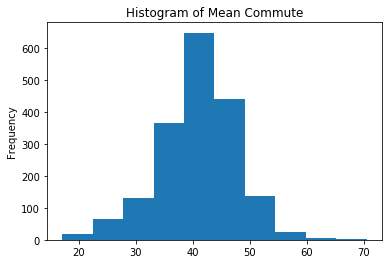

In [52]:
nyc_merge_census_tract_df.MeanCommute.plot(kind='hist', title='Histogram of Mean Commute')

In [53]:
# 11.	Impute or remove missing values as you deem fit

#We observe 1 missing value for ChildPoverty and 3 missing values for MeanCOmmute
#Impute ChildPoverty with 0, as 0 percent is the mode
#Impute expcted value=mean of MeanCommute field as its roughly follows a normal distribution
nyc_merge_census_tract_df.ChildPoverty.fillna(0, inplace=True)
nyc_merge_census_tract_df.drop(['Z_num_checkins'], axis=1, inplace=True)
nyc_merge_census_tract_df.MeanCommute.fillna(nyc_merge_census_tract_df.MeanCommute.mean(), inplace=True)

In [54]:
# 12.	Construct a correlogram of all the variables, output the correlation values to an external excel file

nyc_merge_census_tract_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1839 entries, 0 to 1880
Data columns (total 34 columns):
TotalPop           1839 non-null int64
Men                1839 non-null int64
Women              1839 non-null int64
Hispanic           1839 non-null float64
White              1839 non-null float64
Black              1839 non-null float64
Native             1839 non-null float64
Asian              1839 non-null float64
Citizen            1839 non-null int64
Income             1839 non-null float64
IncomeErr          1839 non-null float64
IncomePerCap       1839 non-null float64
IncomePerCapErr    1839 non-null float64
Poverty            1839 non-null float64
ChildPoverty       1839 non-null float64
Professional       1839 non-null float64
Service            1839 non-null float64
Office             1839 non-null float64
Construction       1839 non-null float64
Production         1839 non-null float64
Drive              1839 non-null float64
Carpool            1839 non-null float64

Index(['TotalPop', 'Men', 'Women', 'Hispanic', 'White', 'Black', 'Native',
       'Asian', 'Citizen', 'Income', 'IncomeErr', 'IncomePerCap',
       'IncomePerCapErr', 'Poverty', 'ChildPoverty', 'Professional', 'Service',
       'Office', 'Construction', 'Production', 'Drive', 'Carpool', 'Transit',
       'Walk', 'OtherTransp', 'WorkAtHome', 'MeanCommute', 'Employed',
       'PrivateWork', 'PublicWork', 'SelfEmployed', 'FamilyWork',
       'Unemployment', 'num_checkins'],
      dtype='object')

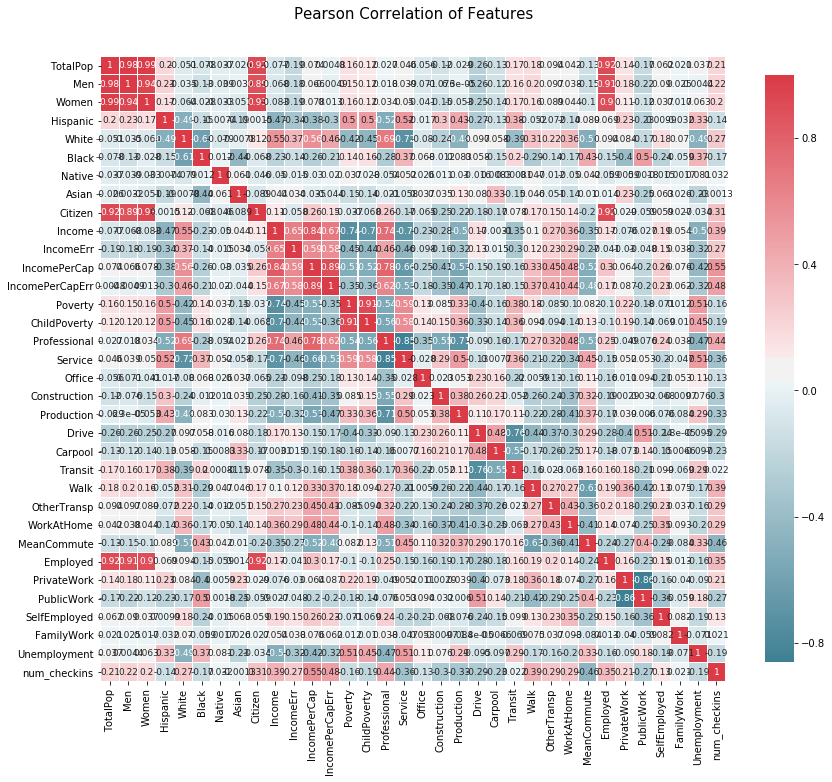

In [56]:
# correlation heatmap of dataset
def correlation_heatmap(df):
    _ , ax = plt.subplots(figsize =(14, 12))
    colormap = sb.diverging_palette(220, 10, as_cmap = True)
    
    
    
    _ = sb.heatmap(
        df.corr(), 
        cmap = colormap,
        square=True, 
        cbar_kws={'shrink':.9 }, 
        ax=ax,
        annot=True, 
        linewidths=0.1,vmax=1.0, linecolor='white',
        annot_kws={'fontsize':9 }
    )
    
    plt.title('Pearson Correlation of Features', y=1.05, size=15)
    return df.corr()

nyc_merge_census_corr = correlation_heatmap(nyc_merge_census_tract_df)
nyc_merge_census_corr.to_csv('nyc_pearson_correlation.csv')
nyc_merge_census_corr.columns

In [63]:
# 13.	Split the dataset into dependent and independent variables, with the dependent variable being total number of check-ins

nyc_census_X = nyc_merge_census_tract_df.drop(['num_checkins'],axis=1)
nyc_census_Y = nyc_merge_census_tract_df['num_checkins']

0     1
1     1
2    76
3    77
4     4
Name: num_checkins, dtype: int64

In [78]:
# 14.	Do min-max scaling on the independent variables
from sklearn.preprocessing import MinMaxScaler

def scale_min_max(series):
    scaler_ = MinMaxScaler()
    return scaler_.fit_transform(series.values.reshape(-1,1))

In [92]:
import seaborn as sb
for col in nyc_census_X.columns:
    nyc_census_X[col] = scale_min_max(nyc_census_X[col])
nyc_census_X.head()
#Every column is centered around mean=0, and variance=1

,TotalPop,Men,Women,Hispanic,White,Black,Native,Asian,Citizen,Income,...,Walk,OtherTransp,WorkAtHome,MeanCommute,Employed,PrivateWork,PublicWork,SelfEmployed,FamilyWork,Unemployment
0,0.185971,0.196593,0.176729,0.792887,0.023092,0.160,0.000000,0.046771,0.157807,0.265214,...,0.048253,0.000000,0.000000,0.485019,0.180017,0.629344,0.406015,0.124464,0.000000,0.122807
1,0.203689,0.214222,0.194525,0.655858,0.036145,0.307,0.000000,0.003341,0.177959,0.277161,...,0.023295,0.008993,0.047297,0.522472,0.208754,0.453668,0.634085,0.107296,0.153846,0.151515
2,0.202443,0.189081,0.214068,0.680962,0.016064,0.324,0.000000,0.000000,0.153305,0.095858,...,0.143095,0.028777,0.038288,0.406367,0.165296,0.517375,0.533835,0.163090,0.000000,0.138756
3,0.088660,0.088515,0.088785,0.579498,0.090361,0.290,0.000000,0.023385,0.066795,0.119836,...,0.049917,0.043165,0.139640,0.529963,0.084097,0.552124,0.388471,0.330472,0.000000,0.306220
4,0.293698,0.244347,0.336634,0.639121,0.016064,0.311,0.026549,0.036748,0.236361,0.035204,...,0.071547,0.017986,0.000000,0.541199,0.195678,0.440154,0.533835,0.330472,0.000000,0.274322


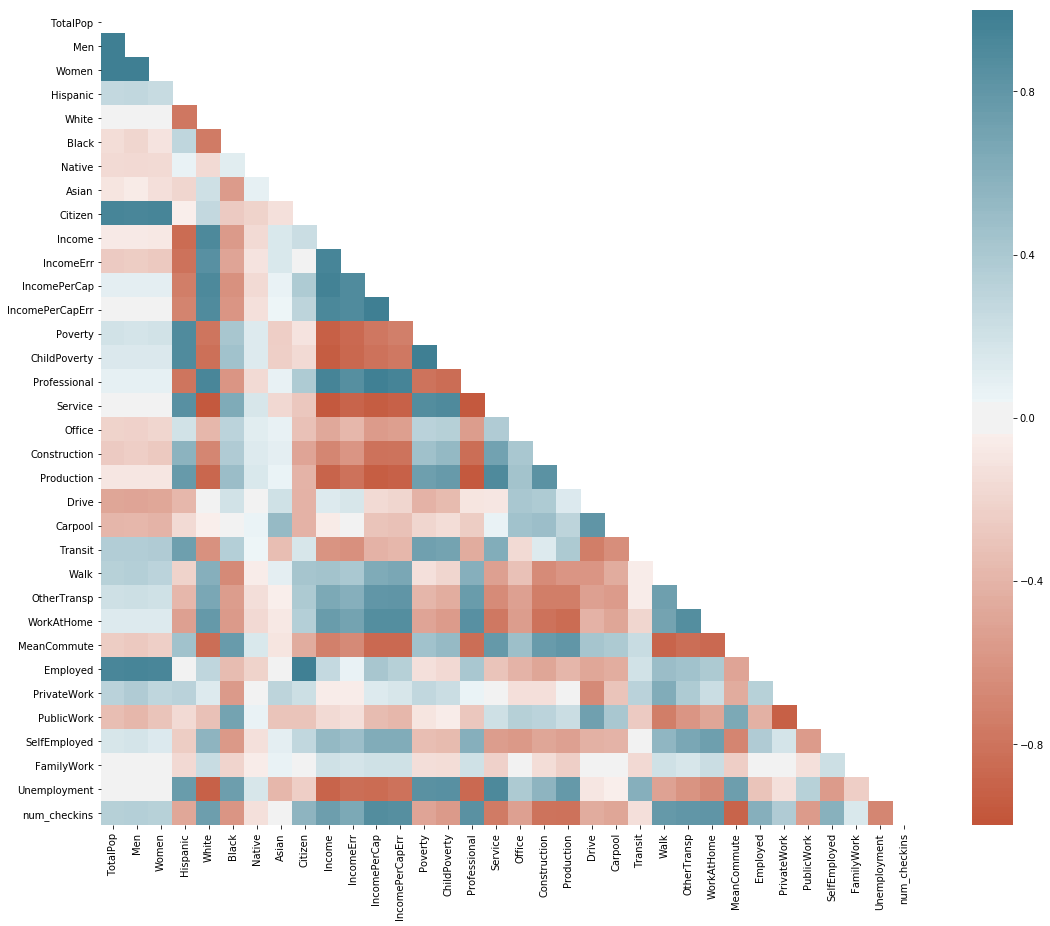

In [100]:
plt.figure(figsize=(20,15))
# Generate a mask for the upper triangle
mask = np.zeros_like(nyc_merge_census_corr.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sb.heatmap(nyc_merge_census_corr.corr(), mask=mask, vmin=-1, vmax=1, center=0, cmap=sb.diverging_palette(20, 220, n=200),square=True)